In [48]:
import pandas as pd
import os
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from pathlib import Path
import numpy as np
from scipy.stats import boxcox
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [30]:
def inverse_boxcox(y, lmbda):
    """
    Reverte a transformação Box-cox para a escala original
    """
    if lmbda == 0:
        return np.exp(y)
    return np.exp(np.log(lmbda * y + 1)/ lmbda)

In [31]:
CAMINHO_RAIZ = Path(os.getcwd()).resolve().parent.parent
OUTPUT = CAMINHO_RAIZ / 'out' / 'dengue_pernambuco'
os.makedirs(OUTPUT, exist_ok=True)

dengue_pe = pd.read_excel(CAMINHO_RAIZ / 'data' / 'dengue_pernambuco.xlsx')

In [32]:
dengue_pe.head()

,semana,valor
0,2000-01-08,686
1,2000-01-15,611
2,2000-01-22,614
3,2000-01-29,598
4,2000-02-05,785


In [33]:
dengue_pe['semana'] = pd.to_datetime(dengue_pe['semana'])
dengue_pe.set_index('semana', inplace=True)
dengue_pe.sort_index(inplace=True)

Divisão do Treinamento

In [34]:
n_obs = len(dengue_pe)
p_train = 0.50
p_val = 0.25
n_train = int(n_obs * p_train)
n_val = int(n_obs * p_val)
n_test = n_obs - n_train - n_val

dengue_train = dengue_pe.iloc[:n_train]
dengue_val = dengue_pe.iloc[n_train: n_train + n_val]
dengue_test = dengue_pe.iloc[n_train + n_val:]

In [35]:
# lambda_boxcox: O parâmetro ideal (lambda) encontrado. Se lambda=0, é a transformação logarítmica.
data_boxcox, lambda_boxcox = boxcox(dengue_pe['valor'])
lambda_boxcox = round(lambda_boxcox, 3)

ts_train_boxcox = boxcox(dengue_train['valor'], lambda_boxcox)
dengue_train_boxcox = pd.DataFrame(ts_train_boxcox, index=dengue_train.index, columns=['valor_bc'])

Treinamento do Modelo SARIMA

In [36]:
order = (0, 1, 1)
seasonal_order = (2, 1, 0, 52)

model = SARIMAX(dengue_train_boxcox['valor_bc'],
                order=order,
                seasonal_order=seasonal_order,
                enforce_stationarity=False,
                enforce_invertibility=False)


results = model.fit(disp=False)

C:\Users\ACER\PycharmProjects\Series_temporais\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  self._init_dates(dates, freq)
C:\Users\ACER\PycharmProjects\Series_temporais\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  self._init_dates(dates, freq)


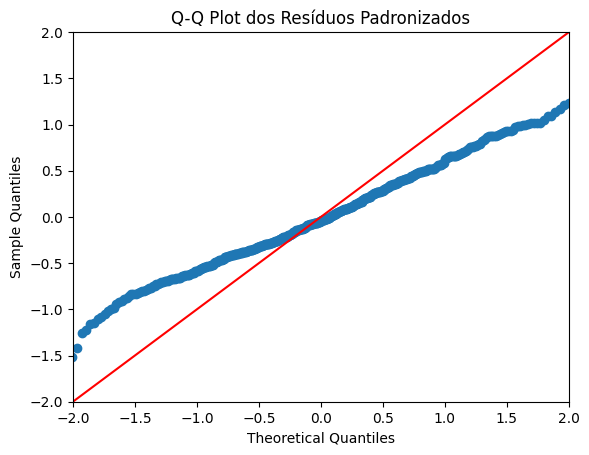

In [60]:
residuals = results.resid
residuals_std = (residuals - np.mean(residuals)) / np.std(residuals)
sm.qqplot(residuals_std, line='45', fit=True)
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.title("Q-Q Plot dos Resíduos Padronizados")
plt.savefig(OUTPUT / 'qqplot.png')
plt.show()


<Figure size 800x500 with 0 Axes>

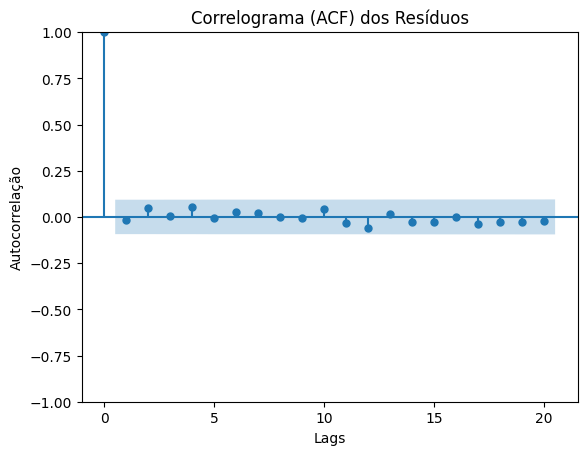

In [59]:
# Correlograma (ACF)
plt.figure(figsize=(8,5))
plot_acf(residuals_std, lags=20, alpha=0.05)  # alpha=0.05 adiciona as bandas de confiança
plt.title("Correlograma (ACF) dos Resíduos")
plt.xlabel("Lags")
plt.ylabel("Autocorrelação")
plt.savefig(OUTPUT / 'acf.png')
plt.show()

<Figure size 800x500 with 0 Axes>

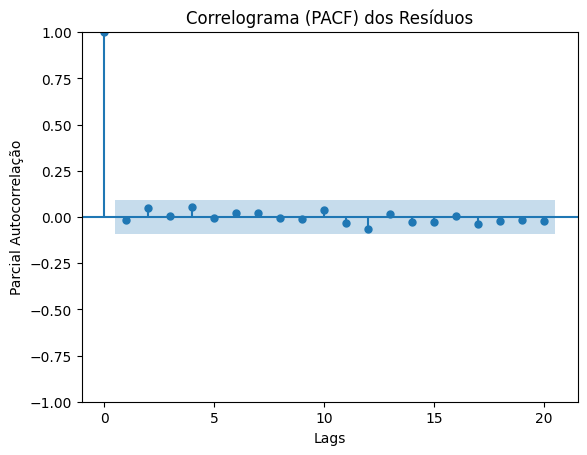

In [58]:
plt.figure(figsize=(8,5))
plot_pacf(residuals_std, lags=20, alpha=0.05, method='ywm')
plt.title("Correlograma (PACF) dos Resíduos")
plt.xlabel("Lags")
plt.ylabel("Parcial Autocorrelação")
plt.savefig(OUTPUT / 'pacf.png')
plt.show()

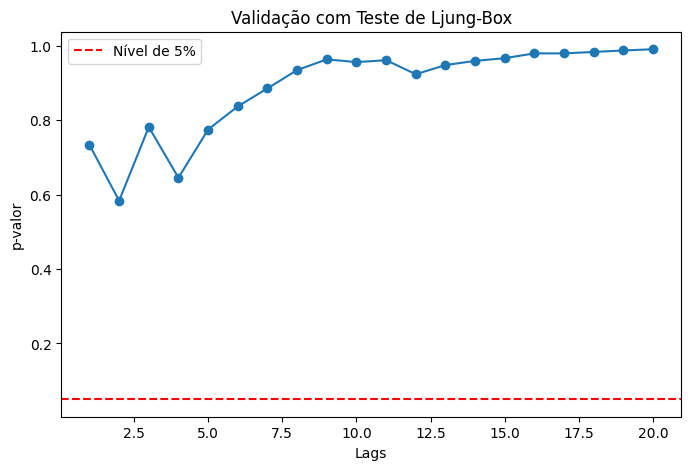

In [57]:
ljung_box = acorr_ljungbox(residuals_std, lags=20, return_df=True)
# Extraindo p-valores
pvalues = ljung_box['lb_pvalue']
# Opcional: gráfico dos p-valores
plt.figure(figsize=(8,5))
plt.plot(ljung_box.index, pvalues, marker='o', linestyle='-')
plt.axhline(y=0.05, color='red', linestyle='--', label='Nível de 5%')
plt.title("Validação com Teste de Ljung-Box")
plt.xlabel("Lags")
plt.ylabel("p-valor")
plt.legend()
plt.savefig(OUTPUT / 'ljung_box.png')
plt.show()

In [56]:
pred_train_bc = results.get_prediction(start=dengue_val.index.min(),
                                       end=dengue_val.index.max(),
                                       dynamic=False)
pred_train_values_bc = pred_train_bc.predicted_mean

pred_train_orig = inverse_boxcox(pred_train_values_bc, lambda_boxcox)
y_train_orig = dengue_val['valor'].values

mse_train = mean_squared_error(y_train_orig, pred_train_orig)
mape_train = mean_absolute_percentage_error(y_train_orig, pred_train_orig)
print(f"MSE Treinamento: {mse_train}")
print(f"MAPE Treinamento: {mape_train}")

MSE Treinamento: 239955.3187585962
MAPE Treinamento: 1.5866188382982627


In [55]:
# O parâmetro steps define quantos passos (semanas) à frente queremos prever.
forecast_test_bc = results.get_forecast(steps=len(dengue_test))
forecast_values_bc = forecast_test_bc.predicted_mean

# Reverte a previsão do teste para a escala original.
forecast_test_orig = inverse_boxcox(forecast_values_bc, lmbda=lambda_boxcox)
y_test_orig = dengue_test['valor'].values

# Cálculo do EQM (MSE) e MAPE para o teste.
mse_test = mean_squared_error(y_test_orig, forecast_test_orig)
mape_test = mean_absolute_percentage_error(y_test_orig, forecast_test_orig)
print(mse_test)
print(mape_test)

2482160.634911946
1.0704620716847235


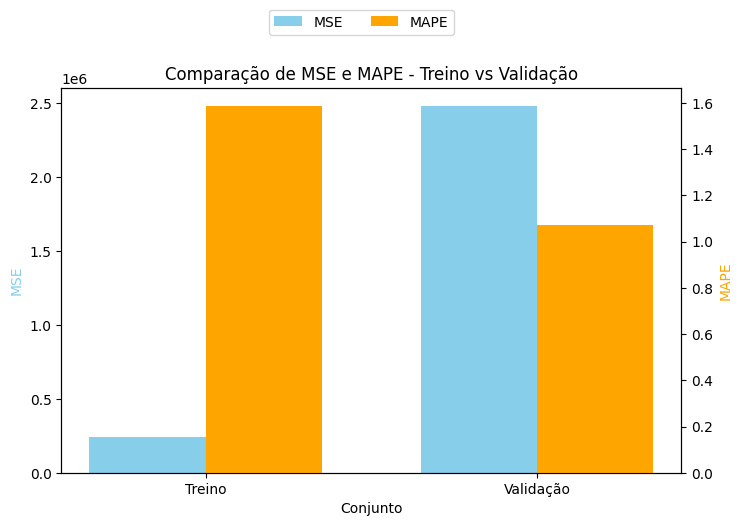

In [62]:
labels = ['Treino', 'Validação']
mse_values = [mse_train, mse_test]
mape_values = [mape_train, mape_test]

x = np.arange(len(labels))  # posições no eixo X
width = 0.35  # largura das barras

fig, ax1 = plt.subplots(figsize=(8,5))

# Barras para MSE
rects1 = ax1.bar(x - width/2, mse_values, width, label='MSE', color='skyblue')

# Criando um segundo eixo Y para o MAPE (porque está em outra escala)
ax2 = ax1.twinx()
rects2 = ax2.bar(x + width/2, mape_values, width, label='MAPE', color='orange')

# Ajustes de rótulos
ax1.set_xlabel('Conjunto')
ax1.set_ylabel('MSE', color='skyblue')
ax2.set_ylabel('MAPE', color='orange')
ax1.set_xticks(x)
ax1.set_xticklabels(labels)
plt.title("Comparação de MSE e MAPE - Treino vs Validação")
# Legenda combinada
fig.legend(loc="upper center", bbox_to_anchor=(0.5, 1.05), ncol=2)
fig.savefig(OUTPUT / 'mse_mape.png')